## 3. Clustering.

In [ ]:
!pip install holidays

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.5 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import holidays

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

### 3.1 Feature Engineering.

#### We start by creating time variables, such as day, week, month or quarter variables. We also create the boolean variables holidays (for days that are holidays in the US) and weekend to identify if it is a weekend.

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [ ]:
# We create US holidays.
us_holidays = holidays.UnitedStates(years=range(2011, 2016))

df['is_holiday'] = df['date'].isin(us_holidays)

In [ ]:
df['weekday_num'] = df['date'].dt.weekday

In [ ]:
df['trimestre'] = df['date'].dt.quarter

In [ ]:
df['year'] = df['date'].dt.year

In [ ]:
df['month'] = df['date'].dt.month

In [ ]:
df['is_weekend'] = df['date'].dt.weekday >= 5

#### We create columns that are useful for the cluster using metrics such as mean, maximum, minimum, sum or standard deviation. We do this with multiple columns.

In [ ]:
# Holiday metrics.
df_holiday_true = df[df['is_holiday'] == True]

df_avg_sales_holiday = df_holiday_true.groupby('item').agg(
    total_sales_holiday = ('n_sales', 'sum'),
    max_sales_holiday = ('n_sales', 'max'),
    min_sales_holiday = ('n_sales', 'min'),
    mean_sales_holiday = ('n_sales', 'mean'),
    std_sales_holiday = ('n_sales', 'std')
)

In [ ]:
# Weekend metrics.
df_finde_true = df[df['is_weekend'] == True]

df_avg_sales_weekend = df_finde_true.groupby('item').agg(
    total_sales_weekend = ('n_sales', 'sum'),
    max_sales_weekend = ('n_sales', 'max'),
    min_sales_weekend = ('n_sales', 'min'),
    mean_sales_weekend = ('n_sales', 'mean'),
    std_sales_weekend = ('n_sales', 'std')
)

In [ ]:
# Quarterly metrics to see if there are differences in item sales between seasons.
for i in range(1, 5):

    globals()[f'df_{i}_trimestre'] = df[df['trimestre'] == i]

    globals()[f'df_avg_sales_{i}_trimestre'] = globals()[f'df_{i}_trimestre'].groupby('item').agg(
      total_sales = ('n_sales', 'sum'),
      max_sales = ('n_sales', 'max'),
      min_sales = ('n_sales', 'min'),
      mean_sales = ('n_sales', 'mean'),
      std_sales = ('n_sales', 'std')
  ).rename(columns=lambda x: f"{x}_{i}_trimestre")


In [ ]:
df_avg_prices = df.groupby('item').agg(
    max_price = ('sell_price', 'max'),
    min_price = ('sell_price', 'min'),
    mean_price = ('sell_price', 'mean'),
    std_price = ('sell_price', 'std')
)

In [ ]:
df_avg_sales = df.groupby('item').agg(
    total_sales = ('n_sales', 'sum'),
    max_sales = ('n_sales', 'max'),
    min_sales = ('n_sales', 'min'),
    mean_sales = ('n_sales', 'mean'),
    std_sales = ('n_sales', 'std')
)

In [ ]:
df_avg_revenue = df.groupby('item').agg(
    total_revenue = ('revenue', 'sum'),
    max_revenue = ('revenue', 'max'),
    min_revenue = ('revenue', 'min'),
    mean_revenue = ('revenue', 'mean'),
    std_revenue = ('revenue', 'std')
)

In [ ]:
# We see the length of the generated data frames of the metrics.
df_avg_revenue.shape

(3024, 5)

In [ ]:
lista_dataframes_avg = [var for var in globals() if isinstance(globals()[var], pd.DataFrame) and var.startswith('df_avg')]

#### We reduce the original dataframe by the items because we want to create the clusters from the items. In this way we eliminate the data and columns that are not useful for our cluster.

In [ ]:
df_reducido = df.drop_duplicates(subset='item', keep='first').reset_index(drop=True)

In [ ]:
df_reducido.drop(['id',
 'store_code',
 'region',
 'n_sales',
 'sell_price',
 'date',
 'revenue',
 'is_holiday',
 'weekday_num',
 'trimestre',
 'year',
 'month',
 'is_weekend'], axis = 1, inplace = True)

In [ ]:
# We check that the length matches the other dataframes created.
df_reducido.shape

(3024, 3)

#### We put together the reduced dataframe with all the metrics.

In [ ]:
for i in lista_dataframes_avg:
  df_reducido = pd.merge(df_reducido, globals()[i], on='item', how='left', left_index=False, right_index=False)

### 3.2 Data Preprocessing.

In [ ]:
df_reducido.set_index('item', inplace=True)

#### We split the numerical columns to be standardised and the categorical columns to be OHE.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Let's assume your DataFrame is called df. Let's select the columns we want to use for clustering.
features = df_reducido.columns.tolist()
df_selected = df_reducido[features]

# Identify numerical and categorical columns.
numeric_features = ['total_sales_holiday',
 'max_sales_holiday',
 'min_sales_holiday',
 'mean_sales_holiday',
 'std_sales_holiday',
 'total_sales_weekend',
 'max_sales_weekend',
 'min_sales_weekend',
 'mean_sales_weekend',
 'std_sales_weekend',
 'total_sales_1_trimestre',
 'max_sales_1_trimestre',
 'min_sales_1_trimestre',
 'mean_sales_1_trimestre',
 'std_sales_1_trimestre',
 'total_sales_2_trimestre',
 'max_sales_2_trimestre',
 'min_sales_2_trimestre',
 'mean_sales_2_trimestre',
 'std_sales_2_trimestre',
 'total_sales_3_trimestre',
 'max_sales_3_trimestre',
 'min_sales_3_trimestre',
 'mean_sales_3_trimestre',
 'std_sales_3_trimestre',
 'total_sales_4_trimestre',
 'max_sales_4_trimestre',
 'min_sales_4_trimestre',
 'mean_sales_4_trimestre',
 'std_sales_4_trimestre',
 'max_price',
 'min_price',
 'mean_price',
 'std_price',
 'total_sales',
 'max_sales',
 'min_sales',
 'mean_sales',
 'std_sales',
 'total_revenue',
 'max_revenue',
 'min_revenue',
 'mean_revenue',
 'std_revenue']

categorical_features = ['category',
 'department']


In [ ]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [ ]:
kmeans_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("Imputer", KNNImputer()),
    ("RobustScaler", RobustScaler(quantile_range = (0, 99.0)))
])

### 3.3 Training and creation of clusters.

#### We start by training our KMeans model with several clusters to see which one is the right one through the elbow curve.

In [ ]:
# Train the model.
df_selected_scaled = kmeans_pipeline.fit_transform(df_selected)

In [ ]:
sse = {}

for k in range(2, 15):

    print(f"Fitting pipe with {k} clusters")

    clustering_model = KMeans(n_clusters = k)
    clustering_model.fit(df_selected_scaled)

    sse[k] = clustering_model.inertia_

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters


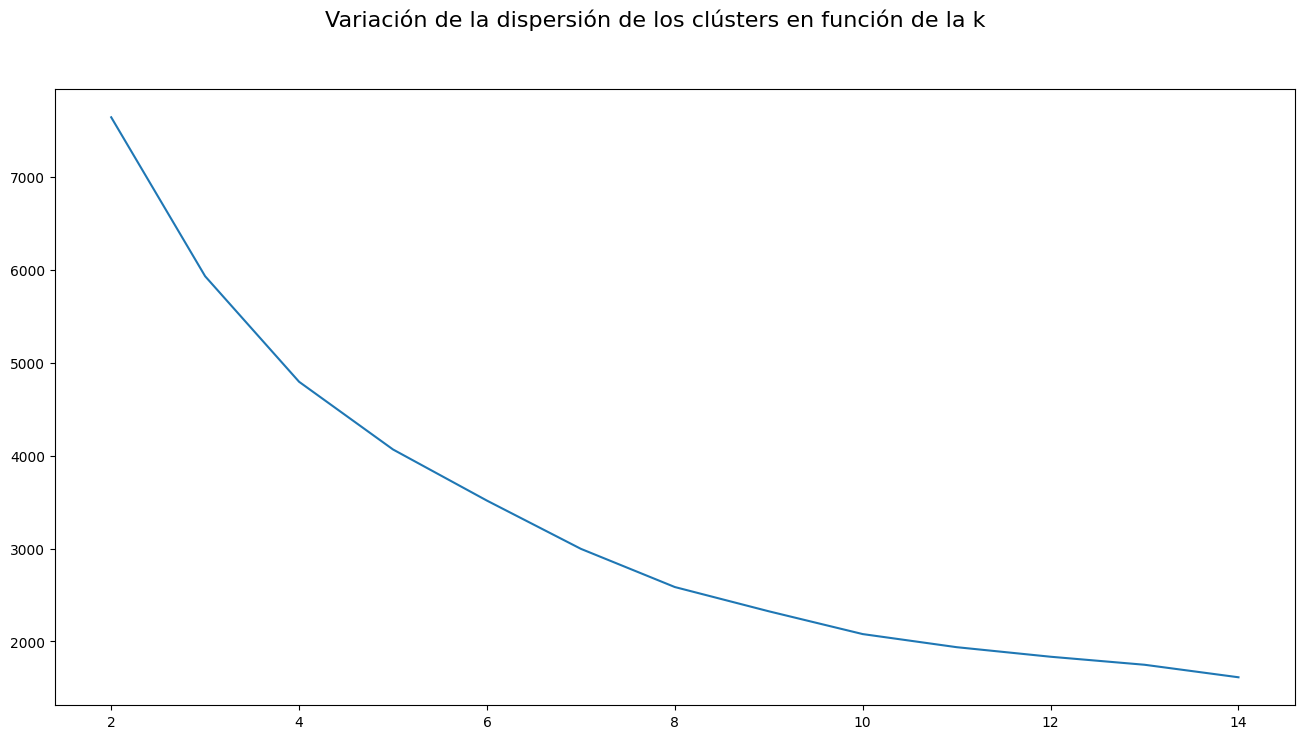

In [ ]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

#### We trained our model and found that the best cluster for our data was the one with 4 groups. Although we trained with other clusters such as 3, 6 or 8, we decided to stick with the 4 cluster.

In [ ]:
kmeans_pipeline_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("Imputer", KNNImputer()),
    ("RobustScaler", RobustScaler(quantile_range = (0, 99.0))),
    ("Clustering", KMeans(n_clusters = 4, random_state = 175))
])

In [ ]:
kmeans_pipeline_final.fit(df_selected)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['total_sales_holiday',
                                                   'max_sales_holiday',
                                                   'min_sales_holiday',
                                                   'mean_sales_holiday',
                                                   'std_sales_holiday',
                                                   'total_sales_weekend',
                                                   'max_sales_weekend',
                                                   'min_sales_weekend',
                                                   'mean_sales_weekend',
                                                   'std_sales_weekend',
                                                   'total_sales_1_trimestre',
                                                   'max_...
                                                   'total_sales_4_trimestre',
                                                   'max_sales_4_trimestre',
                                                   'min_sales_4_trimestre',
                                                   'mean_sales_4_trimestre',
                                                   'std_sales_4_trimestre', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['category',
                                                   'department'])])),
                ('Imputer', KNNImputer()),
                ('RobustScaler', RobustScaler(quantile_range=(0, 99.0))),
                ('Clustering', KMeans(n_clusters=4, random_state=175))])

In [ ]:
df_selected_processed = kmeans_pipeline_final[:2].transform(df_selected)

In [ ]:
# Predict the clusters and we assign to the cluster column.
df_selected['cluster'] = kmeans_pipeline_final.predict(df_selected)

#### We prepare a dataframe to make a heat map and analyse the data.

In [ ]:
df_selected['n_items_cluster'] = df_selected.groupby('cluster')['cluster'].transform('count')

In [ ]:
df_to_print = df_selected[['max_price',
 'min_price',
 'mean_price',
 'std_price',
 'total_sales',
 'max_sales',
 'min_sales',
 'mean_sales',
 'std_sales',
 'total_revenue',
 'max_revenue',
 'min_revenue',
 'mean_revenue',
 'std_revenue',
 'total_sales_holiday',
 'max_sales_holiday',
 'min_sales_holiday',
 'mean_sales_holiday',
 'std_sales_holiday',
 'total_sales_weekend',
 'max_sales_weekend',
 'min_sales_weekend',
 'mean_sales_weekend',
 'std_sales_weekend',
 'total_sales_1_trimestre',
 'max_sales_1_trimestre',
 'min_sales_1_trimestre',
 'mean_sales_1_trimestre',
 'std_sales_1_trimestre',
 'total_sales_2_trimestre',
 'max_sales_2_trimestre',
 'min_sales_2_trimestre',
 'mean_sales_2_trimestre',
 'std_sales_2_trimestre',
 'total_sales_3_trimestre',
 'max_sales_3_trimestre',
 'min_sales_3_trimestre',
 'mean_sales_3_trimestre',
 'std_sales_3_trimestre',
 'total_sales_4_trimestre',
 'max_sales_4_trimestre',
 'min_sales_4_trimestre',
 'mean_sales_4_trimestre',
 'std_sales_4_trimestre',
 'n_items_cluster',
 'cluster']]

In [ ]:
df_to_print

,max_price,min_price,mean_price,std_price,total_sales,max_sales,min_sales,mean_sales,std_sales,total_revenue,max_revenue,min_revenue,mean_revenue,std_revenue,total_sales_holiday,max_sales_holiday,min_sales_holiday,mean_sales_holiday,std_sales_holiday,total_sales_weekend,max_sales_weekend,min_sales_weekend,mean_sales_weekend,std_sales_weekend,total_sales_1_trimestre,max_sales_1_trimestre,min_sales_1_trimestre,mean_sales_1_trimestre,std_sales_1_trimestre,total_sales_2_trimestre,max_sales_2_trimestre,min_sales_2_trimestre,mean_sales_2_trimestre,std_sales_2_trimestre,total_sales_3_trimestre,max_sales_3_trimestre,min_sales_3_trimestre,mean_sales_3_trimestre,std_sales_3_trimestre,total_sales_4_trimestre,max_sales_4_trimestre,min_sales_4_trimestre,mean_sales_4_trimestre,std_sales_4_trimestre,n_items_cluster,cluster
item,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,12.74,6.65,11.47,0.74,4093,6,0,0.21,0.58,"45,037.76",65.91,0.00,2.35,6.34,116,4,0,0.22,0.61,1362,6,0,0.25,0.62,1163,6,0,0.23,0.60,780,6,0,0.16,0.51,951,6,0,0.21,0.55,1199,5,0,0.26,0.63,561,2
ACCESORIES_1_002,5.28,2.66,5.28,0.09,5059,11,0,0.26,0.59,"26,708.08",58.08,0.00,1.40,3.14,117,3,0,0.23,0.50,1777,11,0,0.32,0.65,1026,6,0,0.20,0.50,976,3,0,0.20,0.48,1293,6,0,0.28,0.57,1764,11,0,0.38,0.77,561,2
ACCESORIES_1_003,7.94,1.25,3.95,0.13,1435,6,0,0.08,0.32,"5,656.34",23.70,0.00,0.30,1.27,23,2,0,0.04,0.22,544,6,0,0.10,0.38,422,6,0,0.08,0.33,359,4,0,0.07,0.31,318,4,0,0.07,0.30,336,5,0,0.07,0.35,561,2
ACCESORIES_1_004,6.17,5.01,5.98,0.28,39175,25,0,2.05,2.67,"235,367.23",144.31,0.00,12.30,16.13,994,13,0,1.91,2.66,14098,25,0,2.57,3.06,10616,20,0,2.07,2.70,10099,25,0,2.11,2.78,8938,19,0,1.94,2.53,9522,19,0,2.07,2.64,561,2
ACCESORIES_1_005,4.10,2.00,3.84,0.22,14621,15,0,0.76,1.23,"55,667.12",49.48,0.00,2.91,4.63,386,8,0,0.74,1.22,5250,15,0,0.96,1.43,3493,12,0,0.68,1.15,2945,9,0,0.61,1.07,3712,11,0,0.81,1.25,4471,15,0,0.97,1.39,561,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_823,3.58,1.19,3.35,0.23,15388,25,0,0.80,1.71,"50,885.60",74.40,0.00,2.66,5.65,343,12,0,0.66,1.62,5363,19,0,0.98,2.00,4469,16,0,0.87,1.74,3006,14,0,0.63,1.49,3839,14,0,0.83,1.73,4074,25,0,0.89,1.87,1346,0
SUPERMARKET_3_824,3.22,2.40,3.03,0.26,8325,18,0,0.44,0.95,"25,416.59",57.89,0.00,1.33,2.93,200,7,0,0.38,0.89,2768,12,0,0.51,0.96,1918,10,0,0.37,0.84,2687,18,0,0.56,1.16,2161,10,0,0.47,0.92,1559,12,0,0.34,0.82,1346,0
SUPERMARKET_3_825,5.26,2.39,4.93,0.24,13526,20,0,0.71,1.20,"65,804.39",96.00,0.00,3.44,5.83,277,10,0,0.53,1.10,4707,20,0,0.86,1.40,4124,20,0,0.80,1.34,3258,10,0,0.68,1.04,3516,17,0,0.76,1.33,2628,8,0,0.57,1.03,1346,0


In [ ]:
ficha_df = pd.DataFrame()

In [ ]:
for i, col in enumerate(["n_items_cluster","mean_sales", "total_sales", "mean_revenue", "total_revenue", "mean_price","mean_sales_holiday","total_sales_holiday", "mean_sales_weekend","total_sales_weekend", "mean_sales_1_trimestre","total_sales_1_trimestre", "mean_sales_2_trimestre","total_sales_2_trimestre", "mean_sales_3_trimestre","total_sales_3_trimestre", "mean_sales_4_trimestre","total_sales_4_trimestre"]):
    resumen_data = df_to_print[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = pd.concat([ficha_df, resumen_data])

In [ ]:
# We create our multiindex.
out_index = [
    "Nº_items",
    "Ventas_media",
    "Ventas_total",
    "Ganancias_media",
    "Ganancias_totales",
    "Precios",
    "Ventas_holiday_media",
    "Ventas_holiday_total",
    "Ventas_Fin_De_Semana_media",
    "Ventas_Fin_De_Semana_total",
    "Ventas_1_timestre_media",
    "Ventas_1_trimestre_total",
    "Ventas_2_timestre_media",
    "Ventas_2_trimestre_total",
    "Ventas_3_timestre_media",
    "Ventas_3_trimestre_total",
    "Ventas_4_timestre_media",
    "Ventas_4_trimestre_total"
]

inner_index = [
    "Cantidad de items",
    "N_ventas_media",
    "N_ventas_total",
    "Dinero_ganado_media",
    "Dinero_ganado_total",
    "Precio_vendido",
    "Ventas_holiday_media",
    "Ventas_holiday_total",
    "Ventas_Fin_De_Semana",
    "Ventas_Fin_De_Semana_media",
    "Ventas_1_timestre_media",
    "Ventas_1_trimestre_total",
    "Ventas_2_timestre_media",
    "Ventas_2_trimestre_total",
    "Ventas_3_timestre_media",
    "Ventas_3_trimestre_total",
    "Ventas_4_timestre_media",
    "Ventas_4_trimestre_total"
]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))

In [ ]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [ ]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [ ]:
tamaño_clusters = df_to_print.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

#### We draw our heat map and see by column how our clusters are behaving, although later we will see the more detailed analysis in Power BI.

In [ ]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

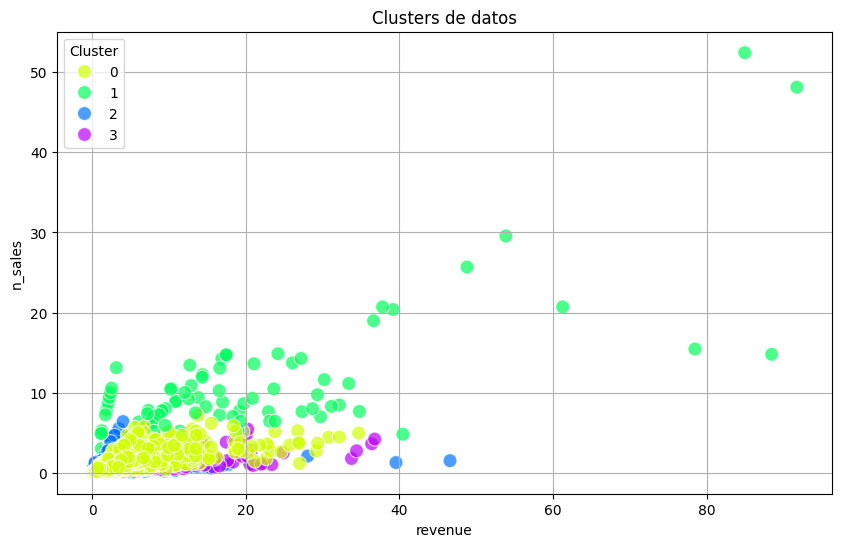

In [ ]:
palette = sns.color_palette("hsv", len(df_to_print['cluster'].unique()))

plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_revenue', y='mean_sales', hue='cluster', data=df_to_print, palette=palette, s=100, alpha=0.7)

plt.title('Clusters de datos')
plt.xlabel('revenue')
plt.ylabel('n_sales')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

#### We prepare the reduced dataframe with the clusters to be able to study it in Power BI.

In [ ]:
df_reducido['cluster'] = df_selected['cluster']

In [ ]:
df_reducido.reset_index(inplace=True)

In [ ]:
float_columns = df_reducido.select_dtypes(include=['float']).columns.tolist()

for i in float_columns:
  df_reducido[i] = df_reducido[i].round(2)
  df_reducido[i] = df_reducido[i].apply(lambda x: f'{x:.2f}'.replace('.', ','))

In [ ]:
df_reducido

,item,category,department,total_sales_holiday,max_sales_holiday,min_sales_holiday,mean_sales_holiday,std_sales_holiday,total_sales_weekend,max_sales_weekend,min_sales_weekend,mean_sales_weekend,std_sales_weekend,total_sales_1_trimestre,max_sales_1_trimestre,min_sales_1_trimestre,mean_sales_1_trimestre,std_sales_1_trimestre,total_sales_2_trimestre,max_sales_2_trimestre,min_sales_2_trimestre,mean_sales_2_trimestre,std_sales_2_trimestre,total_sales_3_trimestre,max_sales_3_trimestre,min_sales_3_trimestre,mean_sales_3_trimestre,std_sales_3_trimestre,total_sales_4_trimestre,max_sales_4_trimestre,min_sales_4_trimestre,mean_sales_4_trimestre,std_sales_4_trimestre,max_price,min_price,mean_price,std_price,total_sales,max_sales,min_sales,mean_sales,std_sales,total_revenue,max_revenue,min_revenue,mean_revenue,std_revenue,cluster
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,116,4,0,"0,22","0,61",1362,6,0,"0,25","0,62",1163,6,0,"0,23","0,60",780,6,0,"0,16","0,51",951,6,0,"0,21","0,55",1199,5,0,"0,26","0,63","12,74","6,65","11,47","0,74",4093,6,0,"0,21","0,58","45037,76","65,91","0,00","2,35","6,34",2
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,117,3,0,"0,22","0,50",1777,11,0,"0,32","0,65",1026,6,0,"0,20","0,50",976,3,0,"0,20","0,48",1293,6,0,"0,28","0,57",1764,11,0,"0,38","0,77","5,28","2,66","5,28","0,09",5059,11,0,"0,26","0,59","26708,08","58,08","0,00","1,40","3,14",2
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,23,2,0,"0,04","0,22",544,6,0,"0,10","0,38",422,6,0,"0,08","0,33",359,4,0,"0,07","0,31",318,4,0,"0,07","0,30",336,5,0,"0,07","0,35","7,94","1,25","3,95","0,13",1435,6,0,"0,08","0,32","5656,34","23,70","0,00","0,30","1,27",2
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,994,13,0,"1,91","2,66",14098,25,0,"2,57","3,06",10616,20,0,"2,07","2,70",10099,25,0,"2,11","2,78",8938,19,0,"1,94","2,53",9522,19,0,"2,07","2,64","6,17","5,01","5,98","0,28",39175,25,0,"2,05","2,67","235367,23","144,30","0,00","12,30","16,13",2
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,386,8,0,"0,74","1,22",5250,15,0,"0,96","1,43",3493,12,0,"0,68","1,15",2945,9,0,"0,61","1,07",3712,11,0,"0,81","1,25",4471,15,0,"0,97","1,39","4,10","2,00","3,84","0,22",14621,15,0,"0,76","1,23","55667,12","49,48","0,00","2,91","4,63",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3019,SUPERMARKET_3_823,SUPERMARKET,SUPERMARKET_3,343,12,0,"0,66","1,62",5363,19,0,"0,98","2,00",4469,16,0,"0,87","1,74",3006,14,0,"0,63","1,49",3839,14,0,"0,83","1,73",4074,25,0,"0,89","1,87","3,58","1,19","3,35","0,23",15388,25,0,"0,80","1,71","50885,60","74,40","0,00","2,66","5,65",0
3020,SUPERMARKET_3_824,SUPERMARKET,SUPERMARKET_3,200,7,0,"0,38","0,89",2768,12,0,"0,51","0,96",1918,10,0,"0,37","0,84",2687,18,0,"0,56","1,16",2161,10,0,"0,47","0,92",1559,12,0,"0,34","0,82","3,22","2,40","3,03","0,26",8325,18,0,"0,44","0,95","25416,59","57,89","0,00","1,33","2,93",0
3021,SUPERMARKET_3_825,SUPERMARKET,SUPERMARKET_3,277,10,0,"0,53","1,10",4707,20,0,"0,86","1,40",4124,20,0,"0,80","1,34",3258,10,0,"0,68","1,04",3516,17,0,"0,76","1,33",2628,8,0,"0,57","1,03","5,26","2,39","4,93","0,24",13526,20,0,"0,71","1,20","65804,39","96,00","0,00","3,44","5,83",0
3022,SUPERMARKET_3_826,SUPERMARKET,SUPERMARKET_3,226,6,0,"0,43","0,95",3745,13,0,"0,68","1,30",2981,11,0,"0,58","1,19",3606,13,0,"0,75","1,35",2971,13,0,"0,65","1,26",2630,12,0,"0,57","1,17","1,54","1,20","1,54","0,01",12188,13,0,"0,64","1,25","18720,10","19,97","0,00","0,98","1,92",0


In [ ]:
df_reducido.to_csv('df_4_cluster_final.csv', sep=';', index=False)